# Make an AnnData using OTG and GWAS catalog datasets

In [1]:
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import gc
import json
import numpy as np
import scipy as sp
import scipy.sparse as spp
import scanpy as sc
from pandas.io.json import json_normalize

In [2]:
pd.set_option('display.max_columns', None)

## Read OTG and GWAS catalog datasets

In [3]:
otg = pd.read_pickle('data/info.pkl').reset_index()
otg = otg[otg.studyId != 'GCST006585'].copy() ## exclude protein levels
otg['uniq_index'] = otg.studyId.astype(str) + '_' + otg.traitReported.astype(str)
otg.rename(columns={'source': 'source_otg'}, inplace=True)

gwas_cat = pd.read_pickle('data/gwas_catalog_aug_14_2021_nonOTG_traits.pkl').reset_index()
gwas_cat['uniq_index'] = gwas_cat['STUDY ACCESSION'].astype(str) + '_' + gwas_cat['DISEASE/TRAIT'].astype(str) + '_' + gwas_cat['MAPPED_TRAIT'].astype(str)

In [4]:
otg.head()

,studyId,traitReported,source_otg,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumstats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,traitCategory,numAssocLoci,nTotal,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,variant_gene_id_pairs,variant_gene_symbol_pairs,uniq_index
0,FINNGEN_R5_AB1_BACTINF_NOS,"Bacterial infection, other or unspecified",FINNGEN,[EFO_0000771],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218637],[],218637,0,20977,infectious disease,2,218637,"(ENSG00000132693, ENSG00000118922)","(CRP, KLF12)","(((ENSG00000132693,), 1_159743672_A_G), ((ENSG...","(((CRP,), 1_159743672_A_G), ((KLF12,), 13_7429...",FINNGEN_R5_AB1_BACTINF_NOS_Bacterial infection...
1,FINNGEN_R5_AB1_DERMATOPHYTOSIS,Dermatophytosis,FINNGEN,[MONDO_0004678],None,2021-05-11,None,None,FINNGEN_R5,True,[European=216472],[],216472,0,1656,infectious disease,1,216472,"(ENSG00000118434,)","(SPACA1,)","(((ENSG00000118434,), 6_87971973_T_C),)","(((SPACA1,), 6_87971973_T_C),)",FINNGEN_R5_AB1_DERMATOPHYTOSIS_Dermatophytosis
2,FINNGEN_R5_AB1_EBV,Infectious mononucleosis,FINNGEN,[EFO_0007326],None,2021-05-11,None,None,FINNGEN_R5,True,[European=214904],[],214904,0,1238,infectious disease,1,214904,"(ENSG00000268043,)","(NBPF12,)","(((ENSG00000268043,), 1_147027146_G_A),)","(((NBPF12,), 1_147027146_G_A),)",FINNGEN_R5_AB1_EBV_Infectious mononucleosis
3,FINNGEN_R5_AB1_GASTROENTERITIS_NOS,Diarrhoea and gastroenteritis of presumed infe...,FINNGEN,[MONDO_0045031],None,2021-05-11,None,None,FINNGEN_R5,True,[European=212553],[],212553,0,15255,infectious disease,1,212553,"(ENSG00000178764,)","(ZHX2,)","(((ENSG00000178764,), 8_122593984_C_T),)","(((ZHX2,), 8_122593984_C_T),)",FINNGEN_R5_AB1_GASTROENTERITIS_NOS_Diarrhoea a...
4,FINNGEN_R5_AB1_GHLAMY_OTHER,Other diseases caused by chlamydiae,FINNGEN,[EFO_1001288],None,2021-05-11,None,None,FINNGEN_R5,True,[European=218772],[],218772,0,167,infectious disease,1,218772,"(ENSG00000112818, ENSG00000069122)","(MEP1A, ADGRF5)","(((ENSG00000112818, ENSG00000069122), 6_468771...","(((MEP1A, ADGRF5), 6_46877116_T_G),)",FINNGEN_R5_AB1_GHLAMY_OTHER_Other diseases cau...


## OTG and GWAS catalog process studies with multiple traits differently

In [5]:
df = otg[['traitReported', 'pmid', 'studyId', 'uniq_index']].drop_duplicates()
df[df.pmid.duplicated(keep=False)].head(10)

,traitReported,pmid,studyId,uniq_index
0,"Bacterial infection, other or unspecified",None,FINNGEN_R5_AB1_BACTINF_NOS,FINNGEN_R5_AB1_BACTINF_NOS_Bacterial infection...
1,Dermatophytosis,None,FINNGEN_R5_AB1_DERMATOPHYTOSIS,FINNGEN_R5_AB1_DERMATOPHYTOSIS_Dermatophytosis
2,Infectious mononucleosis,None,FINNGEN_R5_AB1_EBV,FINNGEN_R5_AB1_EBV_Infectious mononucleosis
3,Diarrhoea and gastroenteritis of presumed infe...,None,FINNGEN_R5_AB1_GASTROENTERITIS_NOS,FINNGEN_R5_AB1_GASTROENTERITIS_NOS_Diarrhoea a...
4,Other diseases caused by chlamydiae,None,FINNGEN_R5_AB1_GHLAMY_OTHER,FINNGEN_R5_AB1_GHLAMY_OTHER_Other diseases cau...
5,Malaria,None,FINNGEN_R5_AB1_MALARIA,FINNGEN_R5_AB1_MALARIA_Malaria
6,Measles,None,FINNGEN_R5_AB1_MEASLES,FINNGEN_R5_AB1_MEASLES_Measles
7,Other bacterial diseases,None,FINNGEN_R5_AB1_OTHER_BACTERIAL,FINNGEN_R5_AB1_OTHER_BACTERIAL_Other bacterial...
8,Other diseases caused by chlamydiae,None,FINNGEN_R5_AB1_OTHER_CHLAMYDIAE,FINNGEN_R5_AB1_OTHER_CHLAMYDIAE_Other diseases...
9,Other spirochaetal diseases,None,FINNGEN_R5_AB1_OTHER_SPIROCHAETAL,FINNGEN_R5_AB1_OTHER_SPIROCHAETAL_Other spiroc...


In [6]:
df = gwas_cat[['DISEASE/TRAIT', 'MAPPED_TRAIT', 'PUBMEDID', 'uniq_index', 'STUDY ACCESSION']].drop_duplicates()
df[df['STUDY ACCESSION'].duplicated(keep=False)].head(30)

,DISEASE/TRAIT,MAPPED_TRAIT,PUBMEDID,uniq_index,STUDY ACCESSION
0,Select biomarker traits,C-reactive protein measurement,17903293,GCST000083_Select biomarker traits_C-reactive ...,GCST000083
1,Select biomarker traits,CCL2 measurement,17903293,GCST000083_Select biomarker traits_CCL2 measur...,GCST000083
2,Waist circumference and related phenotypes,High density lipoprotein cholesterol measurement,18454146,GCST000184_Waist circumference and related phe...,GCST000184
3,Waist circumference and related phenotypes,Triglyceride measurement,18454146,GCST000184_Waist circumference and related phe...,GCST000184
4,Protein quantitative trait loci,Interleukin 18 measurement,18464913,GCST000189_Protein quantitative trait loci_Int...,GCST000189
5,Protein quantitative trait loci,Interleukin-6 receptor measurement,18464913,GCST000189_Protein quantitative trait loci_Int...,GCST000189
6,Protein quantitative trait loci,Soluble transferrin receptor measurement,18464913,GCST000189_Protein quantitative trait loci_Sol...,GCST000189
7,Protein quantitative trait loci,Tumor necrosis factor-alpha measurement,18464913,GCST000189_Protein quantitative trait loci_Tum...,GCST000189
8,Liver enzyme levels,"Alkaline phosphatase measurement, liver enzyme...",18940312,GCST000248_Liver enzyme levels_Alkaline phosph...,GCST000248
9,Liver enzyme levels,"Liver enzyme measurement, serum alanine aminot...",18940312,GCST000248_Liver enzyme levels_Liver enzyme me...,GCST000248


In [7]:
gwas_cat.head()

,STUDY ACCESSION,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,MAPPED_TRAIT,INITIAL SAMPLE SIZE,ASSOCIATION COUNT,rsid,otg_variant_id,otg_v2g_gene_id,otg_v2g_gene_symbol,variant_V2G_id,variant_V2G_symbol,INITIAL_SAMPLE_SIZE_INT,ASSOCIATION COUNT MAPPED TRAIT,uniq_index
0,GCST000083,2008-09-11,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,www.ncbi.nlm.nih.gov/pubmed/17903293,Genome-wide association with select biomarker ...,Select biomarker traits,C-reactive protein measurement,"1,012 European ancestry individuals",21,"(rs2794520,)","(1_159709026_C_T,)","(ENSG00000158716,)","(DUSP23,)","((ENSG00000158716, 1_159709026_C_T),)","((DUSP23, 1_159709026_C_T),)",1012,1,GCST000083_Select biomarker traits_C-reactive ...
1,GCST000083,2008-09-11,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,www.ncbi.nlm.nih.gov/pubmed/17903293,Genome-wide association with select biomarker ...,Select biomarker traits,CCL2 measurement,"1,012 European ancestry individuals",21,"(rs2494250, rs4128725)","(1_159308461_G_C, 1_159436169_T_C)","(ENSG00000179639,)","(FCER1A,)","((ENSG00000179639, 1_159308461_G_C), (ENSG0000...","((FCER1A, 1_159308461_G_C), (FCER1A, 1_1594361...",1012,2,GCST000083_Select biomarker traits_CCL2 measur...
2,GCST000184,2008-06-22,18454146,Chambers JC,2008-05-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18454146,Common genetic variation near MC4R is associat...,Waist circumference and related phenotypes,High density lipoprotein cholesterol measurement,"2,684 Indian Asian ancestry male individuals",4,"(rs3764261,)","(16_56959412_C_A,)","(ENSG00000140853,)","(NLRC5,)","((ENSG00000140853, 16_56959412_C_A),)","((NLRC5, 16_56959412_C_A),)",2684,1,GCST000184_Waist circumference and related phe...
3,GCST000184,2008-06-22,18454146,Chambers JC,2008-05-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/18454146,Common genetic variation near MC4R is associat...,Waist circumference and related phenotypes,Triglyceride measurement,"2,684 Indian Asian ancestry male individuals",4,"(rs1260326,)","(2_27508073_T_C,)","(ENSG00000084734,)","(GCKR,)","((ENSG00000084734, 2_27508073_T_C),)","((GCKR, 2_27508073_T_C),)",2684,1,GCST000184_Waist circumference and related phe...
4,GCST000189,2008-06-22,18464913,Melzer D,2008-05-09,PLoS Genet,www.ncbi.nlm.nih.gov/pubmed/18464913,A genome-wide association study identifies pro...,Protein quantitative trait loci,Interleukin 18 measurement,"1,200 European ancestry individuals",49,"(rs2250417,)","(11_112214593_T_C,)","(ENSG00000197580,)","(BCO2,)","((ENSG00000197580, 11_112214593_T_C),)","((BCO2, 11_112214593_T_C),)",1200,1,GCST000189_Protein quantitative trait loci_Int...


In [8]:
otg = otg.rename(columns={'bestLocus2GenesOrClosest_id': 'gene_id', 'bestLocus2GenesOrClosest_symbol': 'gene_symbol'})

In [9]:
gwas_cat = gwas_cat.rename(columns={
    'STUDY ACCESSION': 'studyId',
    'DATE': 'pubDate',
    'PUBMEDID': 'pmid',
    'FIRST AUTHOR': 'pubAuthor',
    'JOURNAL': 'pubJournal',
    'INITIAL SAMPLE SIZE': 'ancestryInitial',
    'INITIAL_SAMPLE_SIZE_INT': 'nInitial',
    'STUDY': 'pubTitle',
    'MAPPED_TRAIT': 'traitReported',
    'ASSOCIATION COUNT MAPPED TRAIT': 'numAssocLoci',
    'otg_v2g_gene_id': 'gene_id',
    'otg_v2g_gene_symbol': 'gene_symbol'
}).drop(columns=['DATE ADDED TO CATALOG', 'LINK', 'rsid', 'otg_variant_id', 'DISEASE/TRAIT', 'ASSOCIATION COUNT']).set_index('studyId')

gwas_cat

,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,uniq_index
studyId,,,,,,,,,,,,,,
GCST000083,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,Genome-wide association with select biomarker ...,C-reactive protein measurement,"1,012 European ancestry individuals","(ENSG00000158716,)","(DUSP23,)","((ENSG00000158716, 1_159709026_C_T),)","((DUSP23, 1_159709026_C_T),)",1012,1,GCST000083_Select biomarker traits_C-reactive ...
GCST000083,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,Genome-wide association with select biomarker ...,CCL2 measurement,"1,012 European ancestry individuals","(ENSG00000179639,)","(FCER1A,)","((ENSG00000179639, 1_159308461_G_C), (ENSG0000...","((FCER1A, 1_159308461_G_C), (FCER1A, 1_1594361...",1012,2,GCST000083_Select biomarker traits_CCL2 measur...
GCST000184,18454146,Chambers JC,2008-05-04,Nat Genet,Common genetic variation near MC4R is associat...,High density lipoprotein cholesterol measurement,"2,684 Indian Asian ancestry male individuals","(ENSG00000140853,)","(NLRC5,)","((ENSG00000140853, 16_56959412_C_A),)","((NLRC5, 16_56959412_C_A),)",2684,1,GCST000184_Waist circumference and related phe...
GCST000184,18454146,Chambers JC,2008-05-04,Nat Genet,Common genetic variation near MC4R is associat...,Triglyceride measurement,"2,684 Indian Asian ancestry male individuals","(ENSG00000084734,)","(GCKR,)","((ENSG00000084734, 2_27508073_T_C),)","((GCKR, 2_27508073_T_C),)",2684,1,GCST000184_Waist circumference and related phe...
GCST000189,18464913,Melzer D,2008-05-09,PLoS Genet,A genome-wide association study identifies pro...,Interleukin 18 measurement,"1,200 European ancestry individuals","(ENSG00000197580,)","(BCO2,)","((ENSG00000197580, 11_112214593_T_C),)","((BCO2, 11_112214593_T_C),)",1200,1,GCST000189_Protein quantitative trait loci_Int...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCST90019505,33462484,Sinnott-Armstrong N,2021-01-18,Nat Genet,Genetics of 35 blood and urine biomarkers in t...,Bilirubin measurement,"291,512 European ancestry individuals, 5,007 A...","(ENSG00000185038, ENSG00000085982, ENSG0000008...","(MROH2A, USP40, ATG16L1, UGT1A9, APOE, TM6SF2,...","((ENSG00000185038, 2_233800222_G_C), (ENSG0000...","((MROH2A, 2_233800222_G_C), (USP40, 2_23352742...",302607,17,GCST90019505_Direct bilirubin levels_Bilirubin...
GCST90020047,34319593,Li N,2021-07-28,Int J Cancer,Genetic variants of CYP4F12 gene are associate...,Glioma,"485 Han Chinese ancestry cases, 485 Han Chines...","(ENSG00000186204,)","(CYP4F12,)","((ENSG00000186204, 19_15696495_T_C),)","((CYP4F12, 19_15696495_T_C),)",970,1,GCST90020047_Glioma_Glioma
GCST90020091,34255042,Schmitz D,2021-07-13,J Clin Endocrinol Metab,Genome-Wide Association Study of Estradiol Lev...,Estradiol measurement,"13,367 European ancestry male cases, 134,323 E...","(ENSG00000239697, ENSG00000125885, ENSG0000010...","(TNFSF12, MCM8, SULT2A1, FKBP4, ABO, CYP3A7, U...","((ENSG00000239697, 17_7629697_C_T), (ENSG00000...","((TNFSF12, 17_7629697_C_T), (MCM8, 20_5967581_...",147690,7,GCST90020091_Estradiol levels_Estradiol measur...


In [10]:
gwas_cat.loc[['GCST009698']]

,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,uniq_index
studyId,,,,,,,,,,,,,,
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Acylcarnitine measurement,"1,954 Chinese ancestry individuals","(ENSG00000134538, ENSG00000171503, ENSG0000011...","(SLCO1B1, ETFDH, COQ5, TMEM258)","((ENSG00000134538, 12_21178615_T_C), (ENSG0000...","((SLCO1B1, 12_21178615_T_C), (ETFDH, 4_1587005...",1954,5,GCST009698_Metabolite levels_Acylcarnitine mea...
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Ceramide measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296, ENSG00000111700, ENSG0000013...","(SPTLC3, SLCO1B3, HNF1A, CCNG1)","((ENSG00000172296, 20_12978039_A_G), (ENSG0000...","((SPTLC3, 20_12978039_A_G), (SLCO1B3, 12_20858...",1954,16,GCST009698_Metabolite levels_Ceramide measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Glycine measurement,"1,954 Chinese ancestry individuals","(ENSG00000021826,)","(CPS1,)","((ENSG00000021826, 2_210675783_C_A),)","((CPS1, 2_210675783_C_A),)",1954,1,GCST009698_Metabolite levels_Glycine measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Proline measurement,"1,954 Chinese ancestry individuals","(ENSG00000100033,)","(PRODH,)","((ENSG00000100033, 22_18923032_C_T),)","((PRODH, 22_18923032_C_T),)",1954,1,GCST009698_Metabolite levels_Proline measurement
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Sphingolipid measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296, ENSG00000204388, ENSG0000013...","(SPTLC3, HSPA1B, SLCO5A1, A4GALT, ABCA7, SYNE2)","((ENSG00000172296, 20_12978039_A_G), (ENSG0000...","((SPTLC3, 20_12978039_A_G), (HSPA1B, 6_3184519...",1954,11,GCST009698_Metabolite levels_Sphingolipid meas...
GCST009698,31628463,Chai JF,2019-10-19,Hum Mol Genet,Associations with metabolites in Chinese sugge...,Sphingomyelin measurement,"1,954 Chinese ancestry individuals","(ENSG00000172296,)","(SPTLC3,)","((ENSG00000172296, 20_12978039_A_G), (ENSG0000...","((SPTLC3, 20_12978039_A_G), (SPTLC3, 20_129780...",1954,4,GCST009698_Metabolite levels_Sphingomyelin mea...


In [11]:
gwas = pd.concat([gwas_cat.assign(source='gwascat'), otg.set_index('studyId').assign(source='otg')], axis=0).reset_index().set_index('uniq_index')
gwas = gwas[~gwas.gene_symbol.isnull()]
gwas.head(20)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,
GCST000083_Select biomarker traits_C-reactive protein measurement,GCST000083,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,Genome-wide association with select biomarker ...,C-reactive protein measurement,"1,012 European ancestry individuals","(ENSG00000158716,)","(DUSP23,)","((ENSG00000158716, 1_159709026_C_T),)","((DUSP23, 1_159709026_C_T),)",1012,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000083_Select biomarker traits_CCL2 measurement,GCST000083,17903293,Benjamin EJ,2007-09-19,BMC Med Genet,Genome-wide association with select biomarker ...,CCL2 measurement,"1,012 European ancestry individuals","(ENSG00000179639,)","(FCER1A,)","((ENSG00000179639, 1_159308461_G_C), (ENSG0000...","((FCER1A, 1_159308461_G_C), (FCER1A, 1_1594361...",1012,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000184_Waist circumference and related phenotypes_High density lipoprotein cholesterol measurement,GCST000184,18454146,Chambers JC,2008-05-04,Nat Genet,Common genetic variation near MC4R is associat...,High density lipoprotein cholesterol measurement,"2,684 Indian Asian ancestry male individuals","(ENSG00000140853,)","(NLRC5,)","((ENSG00000140853, 16_56959412_C_A),)","((NLRC5, 16_56959412_C_A),)",2684,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000184_Waist circumference and related phenotypes_Triglyceride measurement,GCST000184,18454146,Chambers JC,2008-05-04,Nat Genet,Common genetic variation near MC4R is associat...,Triglyceride measurement,"2,684 Indian Asian ancestry male individuals","(ENSG00000084734,)","(GCKR,)","((ENSG00000084734, 2_27508073_T_C),)","((GCKR, 2_27508073_T_C),)",2684,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000189_Protein quantitative trait loci_Interleukin 18 measurement,GCST000189,18464913,Melzer D,2008-05-09,PLoS Genet,A genome-wide association study identifies pro...,Interleukin 18 measurement,"1,200 European ancestry individuals","(ENSG00000197580,)","(BCO2,)","((ENSG00000197580, 11_112214593_T_C),)","((BCO2, 11_112214593_T_C),)",1200,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000189_Protein quantitative trait loci_Interleukin-6 receptor measurement,GCST000189,18464913,Melzer D,2008-05-09,PLoS Genet,A genome-wide association study identifies pro...,Interleukin-6 receptor measurement,"1,200 European ancestry individuals","(ENSG00000160712,)","(IL6R,)","((ENSG00000160712, 1_154453788_C_T),)","((IL6R, 1_154453788_C_T),)",1200,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000189_Protein quantitative trait loci_Soluble transferrin receptor measurement,GCST000189,18464913,Melzer D,2008-05-09,PLoS Genet,A genome-wide association study identifies pro...,Soluble transferrin receptor measurement,"1,200 European ancestry individuals","(ENSG00000160613,)","(PCSK7,)","((ENSG00000160613, 11_117166645_A_G),)","((PCSK7, 11_117166645_A_G),)",1200,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCST000189_Protein quantitative trait loci_Tumor necrosis factor-alpha measurement,GCST000189,18464913,Melzer D,2008-05-09,PLoS Genet,A genome-wide association study identifies pro...,Tumor necrosis factor-alpha measurement,"1,200 European ancestry individuals","(ENSG00000175164,)","(ABO,)","((ENSG00000175164, 9_133273813_T_C),)","((ABO, 9_133273813_T_C),)",1200,1,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals","(ENSG00000165476, ENSG00000112293, ENSG0000017...","(REEP3, 

In [12]:
gwas[gwas.studyId == 'GCST90000255']

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,
GCST90000255_Severe COVID-19 infection with respiratory failure (analysis I),GCST90000255,PMID:32558485,Ellinghaus D,2020-06-17,N Engl J Med,Genomewide Association Study of Severe Covid-1...,Severe COVID-19 infection with respiratory fai...,[European=3815],"(ENSG00000163817, ENSG00000175164)","(SLC6A20, ABO)",NaN,NaN,3815,2,otg,GCST,[MONDO_0100096],False,[],NaN,1610.0,infectious disease,3815.0,"(((ENSG00000163817,), 3_45834967_G_GA), ((ENSG...","(((SLC6A20,), 3_45834967_G_GA), ((ABO,), 9_133..."


## Filter by numAssocLoci and nInitial

In [13]:
gwas = gwas[(gwas.numAssocLoci >= 2) & (gwas.nInitial > 3000)]
gwas.shape

(7827, 25)

In [14]:
pd.options.display.max_rows = 50
pd.options.display.min_rows = 10

In [15]:
gwas['traitEfosStr'] = gwas.traitEfos.fillna('').astype(str)

In [16]:
gwas[gwas.studyId == 'GCST010936']

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,
GCST010936_COVID-19 (critical illness vs population),GCST010936,PMID:33307546,Pairo-Castineira E,2020-12-11,Nature,Genetic mechanisms of critical illness in Covi...,COVID-19 (critical illness vs population),"[European=690715, Hispanic or Latin America, E...","(ENSG00000163817, ENSG00000204536, ENSG0000011...","(SLC6A20, CCHCR1, OAS3, DPP9, ICAM3, IFNAR2)",NaN,NaN,1170871,6,otg,GCST,[MONDO_0100096],False,[],NaN,NaN,infectious disease,1170871.0,"(((ENSG00000163817,), 3_45821460_T_C), ((ENSG0...","(((SLC6A20,), 3_45821460_T_C), ((CCHCR1,), 6_3...",['MONDO_0100096']


## Take the study with the max nInitial for each trait group

In [17]:
#info = info[info.traitEfosStr != '[]']
#idx = info.groupby(['traitEfosStr'])['nInitial'].transform(max) == info['nInitial']
#info = info[idx]
#info.shape

In [18]:
pd.options.display.min_rows = 10
gwas.sort_values('nInitial', ascending=False)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,
GCST90013473_Biological sex,GCST90013473,PMID:33888908,Pirastu N,2021-04-22,Nat Genet,Genetic analyses identify widespread sex-diffe...,Biological sex,[European=2462132],"(ENSG00000173406, ENSG00000033122, ENSG0000014...","(DAB1, LRRC7, BARHL2, KRTCAP2, KIAA0040, BRINP...",NaN,NaN,2462132,162,otg,GCST,[PATO_0000047],False,[],NaN,1301549.0,Uncategorised,2462132.0,"(((ENSG00000173406,), 1_58360875_T_G), ((ENSG0...","(((DAB1,), 1_58360875_T_G), ((LRRC7,), 1_69595...",['PATO_0000047']
GCST007341_Well-being spectrum (multivariate analysis),GCST007341,PMID:30643256,Baselmans BML,2019-01-14,Nat Genet,Multivariate genome-wide analyses of the well-...,Well-being spectrum (multivariate analysis),[European=2083151],"(ENSG00000162426, ENSG00000127483, ENSG0000011...","(SLC45A1, HP1BP3, CSF3R, GRIK3, TAL1, NEGR1, L...",NaN,NaN,2083151,231,otg,GCST,[EFO_0007869],False,[European=287239],287239.0,NaN,measurement,2370390.0,"(((ENSG00000162426,), 1_8422018_C_T), ((ENSG00...","(((SLC45A1,), 1_8422018_C_T), ((HP1BP3,), 1_20...",['EFO_0007869']
GCST011081_COVID-19 (hospitalized vs population) RELEASE 5,GCST011081,PMID:32404885,COVID-19 Host Genetics Initiative,2020-05-13,Eur J Hum Genet,"The COVID-19 Host Genetics Initiative, a globa...",COVID-19 (hospitalized vs population) RELEASE 5,[European=1887658],"(ENSG00000173585, ENSG00000170419, ENSG0000008...","(CCR9, VSTM2A, OAS1, OAS3, DPP9, IFNAR2, AP000...",NaN,NaN,1887658,5,otg,GCST,[MONDO_0100096],True,[],NaN,9986.0,infectious disease,1887658.0,"(((ENSG00000173585,), 3_45848429_A_T), ((ENSG0...","(((CCR9,), 3_45848429_A_T), ((VSTM2A,), 7_5458...",['MONDO_0100096']
GCST90013421_Left-handedness,GCST90013421,PMID:32989287,Cuellar-Partida G,2020-09-28,Nat Hum Behav,Genome-wide association study identifies 48 co...,Left-handedness,[European=1766671],"(ENSG00000126091, ENSG00000143153, ENSG0000016...","(ST3GAL3, ATP1B1, PPP1R21, SH3RF3, ITGAV, FAM1...",NaN,NaN,1766671,42,otg,GCST,[EFO_0009902],False,[],NaN,NaN,phenotype,1766671.0,"(((ENSG00000126091,), 1_43706787_C_T), ((ENSG0...","(((ST3GAL3,), 1_43706787_C_T), ((ATP1B1,), 1_1...",['EFO_0009902']
GCST011073_COVID-19 (RELEASE 5),GCST011073,PMID:32404885,COVID-19 Host Genetics Initiative,2020-05-13,Eur J Hum Genet,"The COVID-19 Host Genetics Initiative, a globa...",COVID-19 (RELEASE 5),[European=1683768],"(ENSG00000169241, ENSG00000163817, ENSG0000018...","(SLC50A1, SLC6A20, CEP97, ABO, OAS2, ADAMTS17,...",NaN,NaN,1683768,8,otg,GCST,[MONDO_0100096],True,[],NaN,38984.0,infectious disease,1683768.0,"(((ENSG00000169241,), 1_155133406_T_G), ((ENSG...","(((SLC50A1,), 1_155133406_T_G), ((SLC6A20,), 3...",['MONDO_0100096']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCST000814_Red blood cell traits_Mean corpuscular hemoglobin,GCST000814,20927387,Kullo IJ,2010-09-28,PLoS One,A genome-wide association study of red blood c...,Mean corpuscular hemoglobin,"3,012 European ancestry individuals","(ENSG00000118514, ENSG00000010704, ENSG0000018...","(ALDH8A1, HFE, TMPRSS6)","((ENSG00000118514, 6_135131014_G_A), (ENSG0000...","((ALDH8A1, 6_135131014_G_A), (HFE, 6_26092913_...",3012,4,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000814_5_Red blood cell traits [RBC count],GCST000814_5,PMID:20927387,Kullo IJ,2010-09-28,PLoS One,A genome-wide association study of red blood c...,Red blood cell traits [RBC count],[European=3012],"(ENSG00000112339, ENSG00000118513)","(HBS1L, MYB)",NaN,NaN,3012,2,otg,GCST,[EFO_0004305],False,[],NaN,NaN,measurement,3012.0,"(((ENSG00000112339,), 6_135097497_C_T), ((ENSG...","(((HBS1L,), 6_135097497_C_T), ((MYB,), 6_13513...",['

## Remove "None of the above" traits

In [19]:
gwas = gwas[~gwas.traitReported.str.contains('above')]
gwas.head(10)

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals","(ENSG00000165476, ENSG00000112293, ENSG0000017...","(REEP3, GPLD1, ABO, NBPF3)","((ENSG00000165476, 10_63515167_A_G), (ENSG0000...","((REEP3, 10_63515167_A_G), (REEP3, 10_63361805...",7751,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Liver enzyme measurement, serum alanine aminotransferase measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Liver enzyme measurement, serum alanine aminot...","7,751 European ancestry individuals","(ENSG00000100347, ENSG00000095485)","(SAMM50, CWF19L1)","((ENSG00000100347, 22_43936690_G_A), (ENSG0000...","((SAMM50, 22_43936690_G_A), (CWF19L1, 10_10010...",7751,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Liver enzyme measurement, serum gamma-glutamyl transferase measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Liver enzyme measurement, serum gamma-glutamyl...","7,751 European ancestry individuals","(ENSG00000157895, ENSG00000100031)","(C12orf43, GGT1)","((ENSG00000157895, 12_121004867_T_C), (ENSG000...","((C12orf43, 12_121004867_T_C), (GGT1, 22_24594...",7751,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000292_Metabolic traits_Inflammatory response,GCST000292,19060910,Sabatti C,2008-12-07,Nat Genet,Genome-wide association analysis of metabolic ...,Inflammatory response,"4,763 Northern Finnish founder individuals","(ENSG00000157895, ENSG00000158716)","(C12orf43, DUSP23)","((ENSG00000157895, 12_120951159_A_C), (ENSG000...","((C12orf43, 12_120951159_A_C), (DUSP23, 1_1597...",4763,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000292_Metabolic traits_Triglyceride measurement,GCST000292,19060910,Sabatti C,2008-12-07,Nat Genet,Genome-wide association analysis of metabolic ...,Triglyceride measurement,"4,763 Northern Finnish founder individuals","(ENSG00000175445, ENSG00000084734)","(LPL, GCKR)","((ENSG00000175445, 8_19973410_C_T), (ENSG00000...","((LPL, 8_19973410_C_T), (GCKR, 2_27508073_T_C))",4763,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000403_Menarche and menopause (age at onset)_Age at menopause,GCST000403,19448621,He C,2009-05-17,Nat Genet,Genome-wide association studies identify loci ...,Age at menopause,"17,438 European ancestry female individuals","(ENSG00000160469, ENSG00000125885, ENSG0000015...","(BRSK1, MCM8, SYCP2L, UIMC1)","((ENSG00000160469, 19_55308477_C_T), (ENSG0000...","((BRSK1, 19_55308477_C_T), (MCM8, 20_5967581_G...",17438,4,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000498_Hematological parameters_Mean corpuscular volume,GCST000498,19820697,Soranzo N,2009-10-11,Nat Genet,A genome-wide meta-analysis identifies 22 loci...,Mean corpuscular volume,"4,627 European ancestry individuals","(ENSG00000112578, ENSG00000100225, ENSG0000011...","(BYSL, FBXO7, ALDH8A1, HFE)","((ENSG00000112578, 6_41957552_T_A), (ENSG00000...","((BYSL, 6_41957552_T_A), (FBXO7, 22_32471541_G...",4627,4,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
GCST000500_Other erythrocyte phenotypes_Erythrocyte count,GCST000500,19862010,Ganesh SK,2009-10-11,Nat Genet,Multiple loci influence erythrocyte phenotypes...,Erythrocyte count,"24,167 European ancestry individuals","(ENSG00000112339, ENSG00000146839)","(HBS1L, ZAN)","((ENSG00000112339, 6

In [20]:
gwas = gwas[~gwas.index.duplicated()].copy()

<AxesSubplot:>

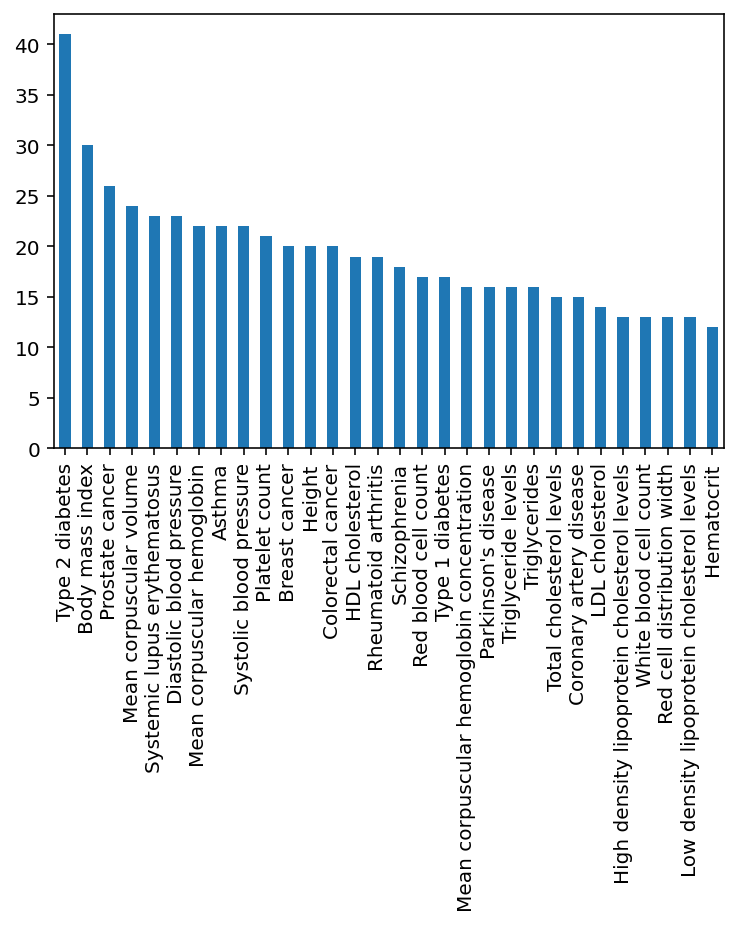

In [21]:
pd.options.display.min_rows = 10
pd.options.display.max_rows = 100
gwas.traitReported.value_counts()[:30].plot(kind='bar')

## Make a study-trait by gene matrix

In [22]:
assert np.all(gwas.explode('gene_id').index == gwas.explode('gene_symbol').index)
assert np.all(gwas.explode('gene_id').studyId == gwas.explode('gene_symbol').studyId)

In [23]:
gwas[gwas.index.duplicated()]

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,


In [24]:
gwas_e = gwas.explode('gene_id').assign(gene_symbol=gwas.explode('gene_symbol').gene_symbol)

In [25]:
gwas_e

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals",ENSG00000165476,REEP3,"((ENSG00000165476, 10_63515167_A_G), (ENSG0000...","((REEP3, 10_63515167_A_G), (REEP3, 10_63361805...",7751,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals",ENSG00000112293,GPLD1,"((ENSG00000165476, 10_63515167_A_G), (ENSG0000...","((REEP3, 10_63515167_A_G), (REEP3, 10_63361805...",7751,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals",ENSG00000175164,ABO,"((ENSG00000165476, 10_63515167_A_G), (ENSG0000...","((REEP3, 10_63515167_A_G), (REEP3, 10_63361805...",7751,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Alkaline phosphatase measurement, liver enzyme...","7,751 European ancestry individuals",ENSG00000142794,NBPF3,"((ENSG00000165476, 10_63515167_A_G), (ENSG0000...","((REEP3, 10_63515167_A_G), (REEP3, 10_63361805...",7751,6,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Liver enzyme measurement, serum alanine aminotransferase measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,Population-based genome-wide association studi...,"Liver enzyme measurement, serum alanine aminot...","7,751 European ancestry individuals",ENSG00000100347,SAMM50,"((ENSG00000100347, 22_43936690_G_A), (ENSG0000...","((SAMM50, 22_43936690_G_A), (CWF19L1, 10_10010...",7751,2,gwascat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_803_2_Fracture of radius and ulna,SAIGE_803_2,None,UKB SAIGE,2018-10-24,None,None,Fracture of radius and ulna,[European=393011],ENSG00000002745,WNT16,NaN,NaN,393011,3,otg,SAIGE,[EFO_0003950],True,[],0,5246,musculoskeletal or connective tissue disease,393011.0,"(((ENSG00000127415,), 4_1011076_T_C), ((ENSG00...","(((IDUA,), 4_1011076_T_C), ((RSPO3,), 6_127138...",['EFO_0003950']
SAIGE_804_Fracture of hand or wrist,SAIGE_804,None,UKB SAIGE,2018-10-24,None,None,Fracture of hand or wrist,[European=391122],ENSG00000002745,WNT16,NaN,NaN,391122,2,otg,SAIGE,[EFO_0009515],True,[],0,3357,musculoskeletal or connective tissue disease,391122.0,"(((ENSG00000002745,), 7_121316386_A_G), ((ENSG...","(((WNT16,), 7_121316386_A_G), ((RNMT,), 18_137...",['EFO_0009515']
SAIGE_804_Fracture of hand or wrist,SAIGE_804,None,UKB SAIGE,2018-10-24,None,None,Fracture of hand or wrist,[European=391122],ENSG00000101654,RNMT,NaN,NaN,391122,2,otg,SAIGE,[EFO_0009515],True,[],0,3357,musculoskeletal or connective tissue disease,391122.0,"(((ENSG00000002745,), 7_121316386_A_G), ((ENSG...","(((WNT16,), 7_121316386_A_G), ((RNMT,), 18_137...",['EFO_0009515']


In [26]:
df = gwas_e[['gene_symbol', 'gene_id']].drop_duplicates().reset_index(drop=True)
df = df[df.gene_symbol.duplicated(keep=False)].sort_values('gene_symbol')
df

,gene_symbol,gene_id
6239,AHRR,ENSG00000063438
12961,AHRR,ENSG00000286169
4829,ATF7,ENSG00000170653
10420,ATF7,ENSG00000267281
6929,ATXN7,ENSG00000163635
8579,ATXN7,ENSG00000285258
3389,IGF2,ENSG00000167244
4742,IGF2,ENSG00000284779
1945,PINX1,ENSG00000254093
4010,PINX1,ENSG00000258724


In [27]:
import gprofiler

g = gprofiler.GProfiler()
df.merge(pd.DataFrame(g.convert(df.gene_id.tolist())), left_on='gene_id', right_on='incoming', how='left')

,gene_symbol,gene_id,converted,description,incoming,n_converted,n_incoming,name,namespaces,query
0,AHRR,ENSG00000063438,ENSG00000063438,aryl-hydrocarbon receptor repressor [Source:HG...,ENSG00000063438,1,1,AHRR,"ARRAYEXPRESS,ENSG",query_1
1,AHRR,ENSG00000286169,nan,nan,ENSG00000286169,1,2,nan,,query_1
2,ATF7,ENSG00000170653,ENSG00000170653,activating transcription factor 7 [Source:HGNC...,ENSG00000170653,1,3,ATF7,"ARRAYEXPRESS,ENSG,HPA,HPA_ACC",query_1
3,ATF7,ENSG00000267281,ENSG00000267281,ATF7-NPFF readthrough [Source:HGNC Symbol;Acc:...,ENSG00000267281,1,4,ATF7-NPFF,"ARRAYEXPRESS,ENSG",query_1
4,ATXN7,ENSG00000163635,ENSG00000163635,ataxin 7 [Source:HGNC Symbol;Acc:HGNC:10560],ENSG00000163635,1,5,ATXN7,"ARRAYEXPRESS,ENSG,HPA,HPA_ACC",query_1
5,ATXN7,ENSG00000285258,nan,nan,ENSG00000285258,1,6,nan,,query_1
6,IGF2,ENSG00000167244,ENSG00000167244,insulin like growth factor 2 [Source:HGNC Symb...,ENSG00000167244,1,7,IGF2,"ARRAYEXPRESS,ENSG,HPA,HPA_ACC",query_1
7,IGF2,ENSG00000284779,ENSG00000284779,novel protein,ENSG00000284779,1,8,nan,"ARRAYEXPRESS,ENSG",query_1
8,PINX1,ENSG00000254093,ENSG00000254093,PIN2 (TERF1) interacting telomerase inhibitor ...,ENSG00000254093,1,9,PINX1,"ARRAYEXPRESS,ENSG,HPA,HPA_ACC",query_1
9,PINX1,ENSG00000258724,ENSG00000258724,PIN2 (TERF1) interacting telomerase inhibitor ...,ENSG00000258724,1,10,PINX1,"ARRAYEXPRESS,ENSG",query_1


In [28]:
gwas.index.nunique()

7800

In [29]:
gwas.shape

(7800, 26)

In [30]:
gwas.loc[gwas.index.duplicated(keep=False)]

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,


In [31]:
pd.set_option('display.max_columns', 10)

In [32]:
'nan' in gwas_e.gene_id.unique()

False

In [33]:
gwas_e.gene_id.isna().any()

False

In [34]:
studytrait_by_gene = gwas_e.reset_index().assign(value=1).pivot(values='value', index='uniq_index', columns='gene_id').fillna(0).astype(int)
studytrait_by_gene

gene_id,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001084,...,ENSG00000286169,ENSG00000286221,ENSG00000286231,ENSG00000286239,ENSG00000286264
uniq_index,,,,,,,,,,,
"FINNGEN_R5_AB1_BACTINF_NOS_Bacterial infection, other or unspecified",0,0,0,0,0,...,0,0,0,0,0
FINNGEN_R5_AB1_OTHER_BACTERIAL_Other bacterial diseases,0,0,0,0,0,...,0,0,0,0,0
FINNGEN_R5_ABDOM_HERNIA_Hernia of abodminal wall,0,0,0,0,0,...,0,0,0,0,0
FINNGEN_R5_AD_AM_EXMORE_Alzheimer's disease (Atypical or mixed) (more controls excluded),0,0,0,0,0,...,0,0,0,0,0
FINNGEN_R5_AD_LO_Alzheimer's disease (Late onset),0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_782_Symptoms involving skin and other integumentary tissue,0,0,0,0,0,...,0,0,0,0,0
SAIGE_803_2_Fracture of radius and ulna,0,0,0,0,0,...,0,0,0,0,0
SAIGE_803_Fracture of upper limb,0,0,0,0,0,...,0,0,0,0,0


<AxesSubplot:>

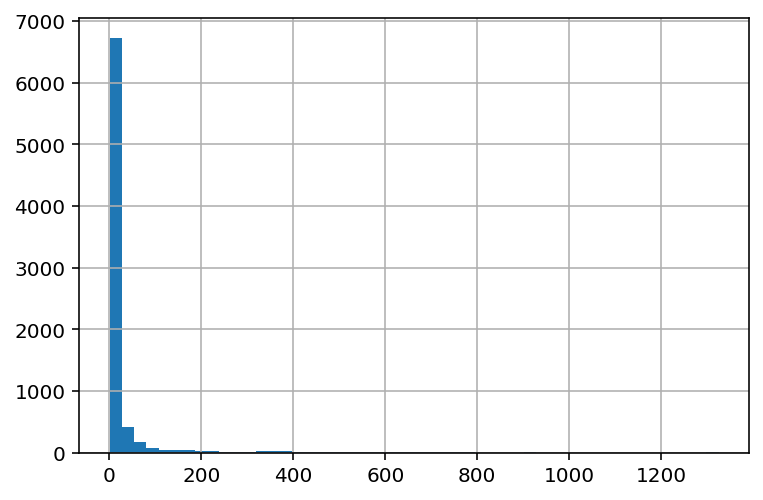

In [35]:
studytrait_by_gene.sum(1).hist(bins=50)

In [36]:
#studytrait_by_gene = studybygene[(studybygene.sum(1)>=2) & (studybygene.sum(1)<=850)]
#studytrait_by_gene.shape

## Make an anndata

In [37]:
gwas.head()

,studyId,pmid,pubAuthor,pubDate,pubJournal,...,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,
"GCST000248_Liver enzyme levels_Alkaline phosphatase measurement, liver enzyme measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,...,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Liver enzyme measurement, serum alanine aminotransferase measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,...,NaN,NaN,NaN,NaN,
"GCST000248_Liver enzyme levels_Liver enzyme measurement, serum gamma-glutamyl transferase measurement",GCST000248,18940312,Yuan X,2008-10-10,Am J Hum Genet,...,NaN,NaN,NaN,NaN,
GCST000292_Metabolic traits_Inflammatory response,GCST000292,19060910,Sabatti C,2008-12-07,Nat Genet,...,NaN,NaN,NaN,NaN,
GCST000292_Metabolic traits_Triglyceride measurement,GCST000292,19060910,Sabatti C,2008-12-07,Nat Genet,...,NaN,NaN,NaN,NaN,


In [38]:
adata = sc.AnnData(studytrait_by_gene, obs=gwas.loc[~gwas.index.duplicated()].loc[studytrait_by_gene.index]) #, var=gene_table.loc[studybygene.columns])
adata.X = spp.csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 7800 × 13447
    obs: 'studyId', 'pmid', 'pubAuthor', 'pubDate', 'pubJournal', 'pubTitle', 'traitReported', 'ancestryInitial', 'gene_id', 'gene_symbol', 'variant_V2G_id', 'variant_V2G_symbol', 'nInitial', 'numAssocLoci', 'source', 'source_otg', 'traitEfos', 'hasSumstats', 'ancestryReplication', 'nReplication', 'nCases', 'traitCategory', 'nTotal', 'variant_gene_id_pairs', 'variant_gene_symbol_pairs', 'traitEfosStr'

In [39]:
adata.obs

,studyId,pmid,pubAuthor,pubDate,pubJournal,...,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,
"FINNGEN_R5_AB1_BACTINF_NOS_Bacterial infection, other or unspecified",FINNGEN_R5_AB1_BACTINF_NOS,None,FINNGEN_R5,2021-05-11,None,...,infectious disease,218637.0,"(((ENSG00000132693,), 1_159743672_A_G), ((ENSG...","(((CRP,), 1_159743672_A_G), ((KLF12,), 13_7429...",['EFO_0000771']
FINNGEN_R5_AB1_OTHER_BACTERIAL_Other bacterial diseases,FINNGEN_R5_AB1_OTHER_BACTERIAL,None,FINNGEN_R5,2021-05-11,None,...,infectious disease,218792.0,"(((ENSG00000132693,), 1_159743672_A_G), ((ENSG...","(((CRP,), 1_159743672_A_G), ((KLF12,), 13_7429...",['EFO_0000771']
FINNGEN_R5_ABDOM_HERNIA_Hernia of abodminal wall,FINNGEN_R5_ABDOM_HERNIA,None,FINNGEN_R5,2021-05-11,None,...,gastrointestinal disease,218792.0,"(((ENSG00000215817,), 1_219568478_G_A), ((ENSG...","(((ZC3H11B,), 1_219568478_G_A), ((OSR1,), 2_19...",['EFO_1001866']
FINNGEN_R5_AD_AM_EXMORE_Alzheimer's disease (Atypical or mixed) (more controls excluded),FINNGEN_R5_AD_AM_EXMORE,None,FINNGEN_R5,2021-05-11,None,...,nervous system disease,112271.0,"(((ENSG00000196141,), 2_200208129_C_T), ((ENSG...","(((SPATS2L,), 2_200208129_C_T), ((APOE,), 19_4...",['EFO_0000249']
FINNGEN_R5_AD_LO_Alzheimer's disease (Late onset),FINNGEN_R5_AD_LO,None,FINNGEN_R5,2021-05-11,None,...,nervous system disease,217541.0,"(((ENSG00000072071,), 19_14242284_T_G), ((ENSG...","(((ADGRL1,), 19_14242284_T_G), ((APOE,), 19_44...",['EFO_1001870']
...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_782_Symptoms involving skin and other integumentary tissue,SAIGE_782,None,UKB SAIGE,2018-10-24,None,...,Uncategorised,408961.0,"(((ENSG00000088280,), 1_23466067_C_A), ((ENSG0...","(((ASAP3,), 1_23466067_C_A), ((SOX21,), 13_949...",[]
SAIGE_803_2_Fracture of radius and ulna,SAIGE_803_2,None,UKB SAIGE,2018-10-24,None,...,musculoskeletal or connective tissue disease,393011.0,"(((ENSG00000127415,), 4_1011076_T_C), ((ENSG00...","(((IDUA,), 4_1011076_T_C), ((RSPO3,), 6_127138...",['EFO_0003950']
SAIGE_803_Fracture of upper limb,SAIGE_803,None,UKB SAIGE,2018-10-24,None,...,musculoskeletal or connective tissue disease,396286.0,"(((ENSG00000146374,), 6_127142500_G_A), ((ENSG...","(((RSPO3,), 6_127142500_G_A), ((CITED2,), 6_14...",['EFO_0009514']


In [40]:
adata.var

""
gene_id
ENSG00000000419
ENSG00000000460
ENSG00000000938
ENSG00000000971
ENSG00000001084
...
ENSG00000286169
ENSG00000286221
ENSG00000286231


In [41]:
ens2symbol = gwas_e[['gene_id', 'gene_symbol']].reset_index(drop=True).drop_duplicates().set_index('gene_id').to_dict()['gene_symbol']

In [42]:
adata.var['gene_id'] = adata.var.index
adata.var.index = [ens2symbol[x] for x in adata.var.gene_id]

In [43]:
adata.var_names_make_unique()

In [44]:
adata.var

,gene_id
DPM1,ENSG00000000419
C1orf112,ENSG00000000460
FGR,ENSG00000000938
CFH,ENSG00000000971
GCLC,ENSG00000001084
...,...
AHRR-1,ENSG00000286169
AC009070.1,ENSG00000286221
AL445423.2,ENSG00000286231
AC093884.1,ENSG00000286239


In [45]:
adata.shape

(7800, 13447)

In [46]:
adata._inplace_subset_obs(adata.X.sum(1).A1 > 0)
adata._inplace_subset_var(adata.X.sum(0).A1 > 0)
adata

AnnData object with n_obs × n_vars = 7800 × 13447
    obs: 'studyId', 'pmid', 'pubAuthor', 'pubDate', 'pubJournal', 'pubTitle', 'traitReported', 'ancestryInitial', 'gene_id', 'gene_symbol', 'variant_V2G_id', 'variant_V2G_symbol', 'nInitial', 'numAssocLoci', 'source', 'source_otg', 'traitEfos', 'hasSumstats', 'ancestryReplication', 'nReplication', 'nCases', 'traitCategory', 'nTotal', 'variant_gene_id_pairs', 'variant_gene_symbol_pairs', 'traitEfosStr'
    var: 'gene_id'

In [47]:
adata.obs.pmid = ['' if not x else x for x in adata.obs.pmid]
adata.obs.pmid = adata.obs.pmid.astype(str)

In [48]:
pd.options.display.max_columns = None

In [49]:
adata.obs

,studyId,pmid,pubAuthor,pubDate,pubJournal,pubTitle,traitReported,ancestryInitial,gene_id,gene_symbol,variant_V2G_id,variant_V2G_symbol,nInitial,numAssocLoci,source,source_otg,traitEfos,hasSumstats,ancestryReplication,nReplication,nCases,traitCategory,nTotal,variant_gene_id_pairs,variant_gene_symbol_pairs,traitEfosStr
uniq_index,,,,,,,,,,,,,,,,,,,,,,,,,,
"FINNGEN_R5_AB1_BACTINF_NOS_Bacterial infection, other or unspecified",FINNGEN_R5_AB1_BACTINF_NOS,,FINNGEN_R5,2021-05-11,None,None,"Bacterial infection, other or unspecified",[European=218637],"(ENSG00000132693, ENSG00000118922)","(CRP, KLF12)",NaN,NaN,218637,2,otg,FINNGEN,[EFO_0000771],True,[],0,20977,infectious disease,218637.0,"(((ENSG00000132693,), 1_159743672_A_G), ((ENSG...","(((CRP,), 1_159743672_A_G), ((KLF12,), 13_7429...",['EFO_0000771']
FINNGEN_R5_AB1_OTHER_BACTERIAL_Other bacterial diseases,FINNGEN_R5_AB1_OTHER_BACTERIAL,,FINNGEN_R5,2021-05-11,None,None,Other bacterial diseases,[European=218792],"(ENSG00000132693, ENSG00000118922)","(CRP, KLF12)",NaN,NaN,218792,2,otg,FINNGEN,[EFO_0000771],True,[],0,21132,infectious disease,218792.0,"(((ENSG00000132693,), 1_159743672_A_G), ((ENSG...","(((CRP,), 1_159743672_A_G), ((KLF12,), 13_7429...",['EFO_0000771']
FINNGEN_R5_ABDOM_HERNIA_Hernia of abodminal wall,FINNGEN_R5_ABDOM_HERNIA,,FINNGEN_R5,2021-05-11,None,None,Hernia of abodminal wall,[European=218792],"(ENSG00000215817, ENSG00000143867, ENSG0000015...","(ZC3H11B, OSR1, BCL2L11, CALD1, PDE3A, NAV3, L...",NaN,NaN,218792,7,otg,FINNGEN,[EFO_1001866],True,[],0,7619,gastrointestinal disease,218792.0,"(((ENSG00000215817,), 1_219568478_G_A), ((ENSG...","(((ZC3H11B,), 1_219568478_G_A), ((OSR1,), 2_19...",['EFO_1001866']
FINNGEN_R5_AD_AM_EXMORE_Alzheimer's disease (Atypical or mixed) (more controls excluded),FINNGEN_R5_AD_AM_EXMORE,,FINNGEN_R5,2021-05-11,None,None,Alzheimer's disease (Atypical or mixed) (more ...,[European=112271],"(ENSG00000196141, ENSG00000130203)","(SPATS2L, APOE)",NaN,NaN,112271,2,otg,FINNGEN,[EFO_0000249],True,[],0,800,nervous system disease,112271.0,"(((ENSG00000196141,), 2_200208129_C_T), ((ENSG...","(((SPATS2L,), 2_200208129_C_T), ((APOE,), 19_4...",['EFO_0000249']
FINNGEN_R5_AD_LO_Alzheimer's disease (Late onset),FINNGEN_R5_AD_LO,,FINNGEN_R5,2021-05-11,None,None,Alzheimer's disease (Late onset),[European=217541],"(ENSG00000072071, ENSG00000130203)","(ADGRL1, APOE)",NaN,NaN,217541,2,otg,FINNGEN,[EFO_1001870],True,[],0,2670,nervous system disease,217541.0,"(((ENSG00000072071,), 19_14242284_T_G), ((ENSG...","(((ADGRL1,), 19_14242284_T_G), ((APOE,), 19_44...",['EFO_1001870']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_782_Symptoms involving skin and other integumentary tissue,SAIGE_782,,UKB SAIGE,2018-10-24,None,None,Symptoms involving skin and other integumentar...,[European=408961],"(ENSG00000088280, ENSG00000125285)","(ASAP3, SOX21)",NaN,NaN,408961,2,otg,SAIGE,[],True,[],0,1816,Uncategorised,408961.0,"(((ENSG00000088280,), 1_23466067_C_A), ((ENSG0...","(((ASAP3,), 1_23466067_C_A), ((SOX21,), 13_949...",[]
SAIGE_803_2_Fracture of radius and ulna,SAIGE_803_2,,UKB SAIGE,2018-10-24,None,None,Fracture of radius and ulna,[European=393011],"(ENSG00000127415, ENSG00000146374, ENSG0000000...","(IDUA, RSPO3, WNT16)",NaN,NaN,393011,3,otg,SAIGE,[EFO_0003950],True,[],0,5246,musculoskeletal or connective tissue disease,393011.0,"(((ENSG00000127415,), 4_1011076_T_C), ((ENSG00...","(((IDUA,), 4_1011076_T_C), ((RSPO3,), 6_127138...",['EFO_0003950']
SAIGE_803_Fracture of upper limb,SAIGE_803,,UKB SAIGE,2018-10-24,None,None,Fracture of upper limb,[European=396286],"(ENSG00000146374, ENSG00000164442, ENSG0000000...","(RSPO3, CITED2, WNT16)",NaN,NaN,396286,3,otg,SAIGE,[EFO_0009514],True,[],0,8521,musculoskeletal or connective tissue disease,396286.0,"(((ENSG00000146374,), 6_127142500_G_A), ((ENSG...","(((RSPO3,), 6_127142500_G_A), ((CITED2,), 6_14...",['EFO_0009514']


In [50]:
adata.obs.hasSumstats = adata.obs.hasSumstats.astype(bool)

In [51]:
adata.obs.nCases = adata.obs.nCases.astype(float)
adata.obs.nReplication = adata.obs.nReplication.astype(float)

In [52]:
sequence_columns = ['ancestryInitial', 'gene_id', 'gene_symbol', 'traitEfos', 'ancestryReplication']

for x in sequence_columns:
    print(x)
    adata.obs[x] = [','.join([str(y) for y in x]) if isinstance(x, list) else '' for x in adata.obs[x]]
    
adata.obs.drop(columns=['variant_gene_id_pairs', 'variant_gene_symbol_pairs', 'variant_V2G_id', 'variant_V2G_symbol'], inplace=True)

ancestryInitial
gene_id
gene_symbol
traitEfos
ancestryReplication


In [53]:
adata.write('data/otg-gwascat-20210816.h5ad')

... storing 'studyId' as categorical
... storing 'pmid' as categorical
... storing 'pubAuthor' as categorical
... storing 'pubDate' as categorical
... storing 'pubJournal' as categorical
... storing 'pubTitle' as categorical
... storing 'traitReported' as categorical
... storing 'ancestryInitial' as categorical
... storing 'gene_id' as categorical
... storing 'gene_symbol' as categorical
... storing 'source' as categorical
... storing 'source_otg' as categorical
... storing 'traitEfos' as categorical
... storing 'ancestryReplication' as categorical
... storing 'traitCategory' as categorical
... storing 'traitEfosStr' as categorical
